# A Metric for Identifying Individual Performance in Punt Coverage

#### Ethan Lee (University of California, Irvine)

The focus on the 2021 - 2022 Big Data Bowl is special teams. This notebook submission attempts to create a new special teams metric and subsequently rank teams and players on punt coverage plays

[Introduction](#whatis) - explains the new metric of interest and how it can be used to analyze members of a punt coverage unit

[Read Data](#ReadData) - read the tracking / non-tracking data

[Clean Data](#CleanData) - filter for plays of interest and merge datapoints

[Query Data](#QueryData) - make queries for the new metric of interest

[Visualize Data](#Visualize) - rank teams and players

<a id="whatis"></a>
# 1. Introduction: Player Distance to Returner at Punt Receive

On NFL punt plays, the punt unit will (1) block for the punter and (2) sprint down the field to get to the ball. In order to limit return yards, punt coverage teams want to get down the field as fast as possible to be in the best possible position to force a fair catch, tackle the returner, or down the ball where it lands.

Thus, the "closeness" of the distance between punt coverage players and the returner at the exact moment the ball is received can be a valuable metric to predict how many yards the returner might gain.

<img src="https://www3.pictures.zimbio.com/gi/New+York+Jets+vs+Detroit+Lions+CdGAYEVdzw-x.jpg" style="width:500px;">

<a id="ReadData"></a>
# 2. Read Data

Before we can do anything, we must read in the data. Note that we will only be using data from the 2018 season.

In [1]:
# Useful libraries
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pff_data = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
play_data = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
game_data = pd.read_csv('../input/nfl-big-data-bowl-2022/games.csv')

# 2018 tracking data only for this case
tracking_data = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2018.csv')

<a id="CleanData"></a>
# 3. Clean Data

This section is broken into four parts: (1) understanding the problem with the given "punt_received" event, (2) finding the "true" punt received event, (3) merging additional data like distance and return yardage, and (4) building our main dataset

### 3.1 The Problem with the "punt_received" Event

We want to analyze all punt return plays at the moment the returner catches the ball. While there is a given "punt_received" event in the tracking data, we want to ensure whether or not that is the correct time frame. Let's test the accuracy of this event by finding the distance between the returner and the ball at that frame.

We will use Andre Roberts' 78-yard punt return touchdown as an example:

At the "punt_received" event at frame 74, the returner Andre Roberts was 11.4 yards away from the ball - This shows that the given "punt_received" label may not be completely accurate for our desired analysis

In [3]:
def get_play_tracking(gameId, playId):
    return tracking_data[(tracking_data['gameId']==gameId)&(tracking_data['playId']==playId)]

andre_roberts_td = get_play_tracking(2018091000, 2626)

def get_returner_id(gameId, playId):
    retId = play_data[(play_data['gameId'] == gameId) & (play_data['playId']==playId)].iloc[0].returnerId
    if type(retId) == str:
        retId = float(retId.split(';')[0])
    if pd.isnull(retId):
        return None
    return retId

andre_roberts_id = get_returner_id(2018091000, 2626)

def get_distance(frame_df, playerId, player2Id):
    player = frame_df[frame_df['nflId'] == playerId].iloc[0]
    if player2Id == 'football':
        player2 = frame_df[frame_df['displayName']=='football'].iloc[0]
    else:
        player2 = frame_df[frame_df['nflId'] == player2Id].iloc[0]
    X2 = player2['x']
    Y2 = player2['y']
    distance = math.sqrt((player['x']-X2)**2 + (player['y']-Y2)**2)
    return distance

receive_df = andre_roberts_td[andre_roberts_td['event'] == 'punt_received']
receive_frame = receive_df.iloc[0]['frameId']
print(receive_frame, get_distance(receive_df, andre_roberts_id, 'football'))
receive_df[receive_df['displayName'].apply(lambda x: x=='Andre Roberts' or x=='football')]

74 11.40074120397442


,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12713572,2018-09-11T01:30:34.300,86.54,9.03,2.57,0.99,0.26,267.57,149.31,punt_received,35527.0,Andre Roberts,19.0,WR,away,74,2018091000,2626,right
12717835,2018-09-11T01:30:34.300,75.14,9.16,30.20,6.23,1.36,NaN,NaN,punt_received,NaN,football,NaN,NaN,football,74,2018091000,2626,right


### 3.2 Finding the "True" Receive Time

To find the "true" receive timeframe, we can start at the perceived "punt_received" event frame and move on to the next timeframe until the ball is at a reasonably close distance to the returner.

In [4]:
def get_true_receive_frame(play_df, returner_id, receive_frame):
    original = play_df[play_df['frameId']==receive_frame]
    found = False
    while True:
        receive_df = play_df[play_df['frameId']==receive_frame]
        try:
            distance = get_distance(receive_df, returner_id, 'football')
        except:
            break
        
        if distance < 0.6:
            found = True
            break
        
        receive_frame += 1
        
    if found:
        df = play_df[play_df['frameId']==receive_frame]
    else:
        df = original
    
    # To identify players of interest = members of coverage team
    try:
        punter_team = df[df['position']=='P'].iloc[0]['team']
    except:
        punter_team = df[df['position']=='K'].iloc[0]['team']
    coverageTeam = [1 if i == punter_team else 0 for i in df['team']]
    df.insert(0, 'isCoverage', coverageTeam, True)
    
    # Add teams abbreviations for play
    game_id = df.iloc[0]['gameId']
    game_df = game_data[game_data['gameId']==game_id]
    if len(game_df) > 1:
        print('ERROR')
    else:
        game = game_df.iloc[0]
    teams = [game['homeTeamAbbr'] if i == 'home' else game['visitorTeamAbbr'] for i in df['team']]
    df.insert(0, 'teamAbbr', teams, True)
                                                                                                    
    return_team = df[df['isCoverage']==0].iloc[0]['teamAbbr']  
    returnTeams = [return_team] * len(df)
    df.insert(1, 'returnTeam', returnTeams, True)
    
    return df

true_receive_df = get_true_receive_frame(andre_roberts_td, andre_roberts_id, receive_frame)
true_receive_df.head()

,teamAbbr,returnTeam,isCoverage,time,x,y,s,a,dis,o,...,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12713375,DET,NYJ,1,2018-09-11T01:30:34.900,47.96,23.66,6.99,0.89,0.70,106.52,...,None,29468.0,Don Muhlbach,48.0,LS,home,80,2018091000,2626,right
12713578,NYJ,NYJ,0,2018-09-11T01:30:34.900,86.82,8.48,0.36,5.41,0.01,268.22,...,None,35527.0,Andre Roberts,19.0,WR,away,80,2018091000,2626,right
12713781,DET,NYJ,1,2018-09-11T01:30:34.900,54.24,20.87,5.50,3.45,0.56,131.82,...,None,37792.0,Nick Bellore,43.0,FB,home,80,2018091000,2626,right
12713984,DET,NYJ,1,2018-09-11T01:30:34.900,63.38,18.38,8.98,1.52,0.90,110.91,...,None,38578.0,Tavon Wilson,32.0,SS,home,80,2018091000,2626,right
12714187,DET,NYJ,1,2018-09-11T01:30:34.900,39.49,18.17,5.41,0.75,0.54,110.14,...,None,40113.0,Sam Martin,6.0,P,home,80,2018091000,2626,right


The following code sample demonstrates why I chose the threshold of 0.6 yards for being a reasonably close distance between returner and ball. By visualizing the distance between the returner and the ball over each time frame, we can tell that there is a clear point in which the distance stays at a low number - the first of those should be the exact time frame for our analysis. 

At the "true_receive" frame 80, the returner Andre Roberts was 0.24 yards away from the ball.

[(72, 15.035059028816615),
 (73, 12.582483856536433),
 (74, 11.40074120397442),
 (75, 8.920022421496485),
 (76, 6.003007579538776),
 (77, 2.965754541427876),
 (78, 0.6041522986797297),
 (79, 2.0873428084528896),
 (80, 0.23706539182260106),
 (81, 0.10295630140987333),
 (82, 0.2969848480983562),
 (83, 0.3969886648255787),
 (84, 0.43416586692185444),
 (85, 0.40804411526206036),
 (86, 0.34132096331751716),
 (87, 0.30413812651491084),
 (88, 0.2942787793912443)]

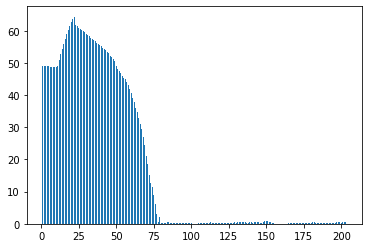

In [5]:
def graph_returner_to_ball_distance_over_time(play_df, returner_id):
    distances = []
    found = False
    for i in sorted(play_df['frameId'].unique()):
        frame_df = play_df[play_df['frameId']==i]
        distance = get_distance(frame_df, returner_id, 'football')
        if not found and distance < 0.6:
            index = i
            found = True
        distances.append((i, distance))
    plt.bar([i[0] for i in distances], [i[1] for i in distances])
    return distances[index-9:index+8]
graph_returner_to_ball_distance_over_time(andre_roberts_td, andre_roberts_id)

### 3.3 Merging Additional Data

Next, we will label the gunners on the play. Gunners are the position group with the sole role to rush toward the returner on a punt to force a fair catch (0 return yards), make a tackle on a return, or down the punt themselves. Since they are the coverage players who are most likely to be closest to the returner on a punt receive, we will be ranking individual gunners and non-gunners later on by the % of plays where they were "close" to the returner. 

In [6]:
# Label who the gunners are from the pff_data
def add_gunners(play_df):
    game = play_df.iloc[0]['gameId']
    play = play_df.iloc[0]['playId']
    gunners = pff_data[(pff_data['gameId']==game) & (pff_data['playId']==play)].iloc[0]['gunners']
    
    # the value = nan = there are no recorded gunners
    if type(gunners) == float:
        play_df.insert(0, 'gunner', [0]*len(play_df.index), True)
    else:
    
        try:
            punter_team = play_df[play_df['position']=='P'].iloc[0]['teamAbbr']
        except:
            punter_team = play_df[play_df['position']=='K'].iloc[0]['teamAbbr']
            #raise ValueError("Long Snapper not found")
        is_gunner = []
        for team, num in zip(play_df['teamAbbr'], play_df['jerseyNumber']):
            found = False

            for g in gunners.split('; '):
                try:
                    if str(int(num)) == g.split()[1] and team == g.split()[0]:
                        found = True
                        break
                except:
                    found = False
                    break

            if found:
                is_gunner.append(1)
            else:
                is_gunner.append(0)
            
        play_df.insert(0, 'gunner', is_gunner, True)
        
    return play_df

true_receive_df = add_gunners(true_receive_df)
true_receive_df[true_receive_df['gunner']==1]

,gunner,teamAbbr,returnTeam,isCoverage,time,x,y,s,a,dis,...,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12715811,1,DET,NYJ,1,2018-09-11T01:30:34.900,82.19,7.38,2.62,4.14,0.28,...,None,42849.0,Bradley Marquez,12.0,WR,home,80,2018091000,2626,right
12716420,1,DET,NYJ,1,2018-09-11T01:30:34.900,67.95,32.73,2.79,2.91,0.26,...,None,43680.0,Charles Washington,45.0,FS,home,80,2018091000,2626,right


Now we will add the distances from the players to the returner.

In [7]:
# Get data for player distances to the returner at the true receive frame
# If there is no labeled returner, then find the distance to the ball
def add_player_distances(play_df, returner_id):
    game_id = play_df.iloc[0]['gameId']
    distances = []
    for index, player in play_df.iterrows():
        if player['displayName'] == 'football':
            continue
        
        if returner_id:
            distances.append(get_distance(play_df, player['nflId'], returner_id))
        else:
            distances.append(get_distance(play_df, player['nflId'], 'football'))
        
    play_df = play_df[play_df['displayName'] != 'football']
    play_df.insert(0, 'distanceToReturner', distances, True)
    return play_df
    
true_receive_df = add_player_distances(true_receive_df, andre_roberts_id)
true_receive_df.sort_values(by='distanceToReturner').head()

,distanceToReturner,gunner,teamAbbr,returnTeam,isCoverage,time,x,y,s,a,...,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12713578,0.000000,0,NYJ,NYJ,0,2018-09-11T01:30:34.900,86.82,8.48,0.36,5.41,...,None,35527.0,Andre Roberts,19.0,WR,away,80,2018091000,2626,right
12716217,4.480179,0,NYJ,NYJ,0,2018-09-11T01:30:34.900,82.34,8.44,3.26,3.46,...,None,43530.0,Charone Peake,17.0,WR,away,80,2018091000,2626,right
12715811,4.758876,1,DET,NYJ,1,2018-09-11T01:30:34.900,82.19,7.38,2.62,4.14,...,None,42849.0,Bradley Marquez,12.0,WR,home,80,2018091000,2626,right
12715405,8.870428,0,NYJ,NYJ,0,2018-09-11T01:30:34.900,79.99,14.14,1.38,2.72,...,None,42590.0,Darryl Roberts,27.0,CB,away,80,2018091000,2626,right
12715202,20.205962,0,DET,NYJ,1,2018-09-11T01:30:34.900,67.02,12.51,8.60,1.64,...,None,41947.0,Christian Jones,52.0,ILB,home,80,2018091000,2626,right


We also bring in an established metric of punt return success: return yardage.

In [8]:
def add_return_yardage(play_df):
    game_id = play_df.iloc[0]['gameId']
    play_id = play_df.iloc[0]['playId']
    
    play = play_data[(play_data['gameId'] == game_id) & (play_data['playId']==play_id)].iloc[0]
    play_df.insert(0, 'kickReturnYardage', [play['kickReturnYardage']] * len(play_df), True)
    return play_df

true_receive_df = add_return_yardage(true_receive_df)
true_receive_df.head()

,kickReturnYardage,distanceToReturner,gunner,teamAbbr,returnTeam,isCoverage,time,x,y,s,...,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12713375,78.0,41.719684,0,DET,NYJ,1,2018-09-11T01:30:34.900,47.96,23.66,6.99,...,None,29468.0,Don Muhlbach,48.0,LS,home,80,2018091000,2626,right
12713578,78.0,0.000000,0,NYJ,NYJ,0,2018-09-11T01:30:34.900,86.82,8.48,0.36,...,None,35527.0,Andre Roberts,19.0,WR,away,80,2018091000,2626,right
12713781,78.0,34.856398,0,DET,NYJ,1,2018-09-11T01:30:34.900,54.24,20.87,5.50,...,None,37792.0,Nick Bellore,43.0,FB,home,80,2018091000,2626,right
12713984,78.0,25.444913,0,DET,NYJ,1,2018-09-11T01:30:34.900,63.38,18.38,8.98,...,None,38578.0,Tavon Wilson,32.0,SS,home,80,2018091000,2626,right
12714187,78.0,48.311748,0,DET,NYJ,1,2018-09-11T01:30:34.900,39.49,18.17,5.41,...,None,40113.0,Sam Martin,6.0,P,home,80,2018091000,2626,right


### 3.4 Obtaining Our Main Dataset

Now we apply this example to all punt returns to obtain our main dataset. This includes muffed punts since a muff (or fumble) counts as an attempted return. 

In [9]:
# Takes 1 minute to run for ~850 punts
distance_data = pd.DataFrame()
punts = play_data[(play_data['gameId'].apply(lambda x: str(x)[:4]=='2018'))&(play_data['specialTeamsPlayType']=='Punt')]
punts = punts[(punts['specialTeamsResult']=='Return')|(punts['specialTeamsResult']=='Muffed')]
punt_ids = [(i,j) for i, j in zip(punts.gameId, punts.playId)]

count = 0
for game, play in zip(punts['gameId'], punts['playId']):
    play_df = get_play_tracking(game, play)
    returner_id = get_returner_id(game, play)
    # some plays do not have the "punt_received" event, so for those we will set a base timeframe at 50 and go from there to find the "true" frame
    try:
        temp = play_df[play_df['event']=='punt_received']
        frame = temp.iloc[0]['frameId']
    except:
        frame=50
    true_receive_frame = get_true_receive_frame(play_df, returner_id, frame)
    true_receive_df = add_gunners(true_receive_frame)
    true_receive_df = add_player_distances(true_receive_df, returner_id)
    true_receive_df = add_return_yardage(true_receive_df)
    distance_data = pd.concat([distance_data, true_receive_df])
    
distance_data

,kickReturnYardage,distanceToReturner,gunner,teamAbbr,returnTeam,isCoverage,time,x,y,s,...,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12070985,5.0,24.052451,0,PHI,ATL,1,2018-09-07T01:18:21.900,51.86,27.53,8.62,...,None,32361.0,Corey Graham,24.0,FS,home,80,2018090600,366,right
12071113,5.0,24.899906,0,ATL,ATL,0,2018-09-07T01:18:21.900,48.39,37.29,7.78,...,None,38707.0,Justin Bethel,28.0,CB,away,80,2018090600,366,right
12071241,5.0,31.732458,0,ATL,ATL,0,2018-09-07T01:18:21.900,57.34,11.06,6.81,...,None,39968.0,Desmond Trufant,21.0,CB,away,80,2018090600,366,right
12071369,5.0,31.038352,0,ATL,ATL,0,2018-09-07T01:18:21.900,44.34,27.24,7.84,...,None,40191.0,Kemal Ishmael,36.0,FS,away,80,2018090600,366,right
12071497,5.0,31.619731,0,PHI,ATL,1,2018-09-07T01:18:21.900,43.41,28.08,8.45,...,None,40408.0,LaRoy Reynolds,50.0,MLB,home,80,2018090600,366,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765941,19.0,31.489390,0,SEA,ARI,1,2018-12-30T23:17:12.600,53.84,24.32,8.67,...,None,46210.0,Shaquem Griffin,49.0,LB,home,89,2018123015,2489,left
766083,19.0,48.083263,0,SEA,ARI,1,2018-12-30T23:17:12.600,76.24,32.59,8.55,...,None,46218.0,Michael Dickson,4.0,P,home,89,2018123015,2489,left
766225,19.0,48.935085,0,ARI,ARI,0,2018-12-30T23:17:12.600,77.78,35.64,7.63,...,None,46657.0,Dennis Gardeck,92.0,LB,away,89,2018123015,2489,left
766367,19.0,51.201685,0,ARI,ARI,0,2018-12-30T23:17:12.600,80.83,45.97,7.62,...,None,46674.0,Zeke Turner,47.0,DB,away,89,2018123015,2489,left


<a id="QueryData"></a>
# 4. Query Data

Now we have for each punt return play:
* Player team
* Who the return team is
* Distance from players to returner
* Kick return yardage

### 4.1 "Close" Players

Given this information, we predict that a "close" player is a punt coverage player who has the effect of lowering return yards by attempting to zone out or tackle the returner.

We will establish the threshold of a "close" player being within 10 yards of the returner at the moment the ball is caught.

Now we will find the number of "close" coverage players for every punt return.

In [10]:
punt_coverage_data = distance_data[distance_data['isCoverage']==1]

# Show that the metric of "close" players is related to the play result = punt return yardage
# For each play, list the return yardage vs the number of "close" players to the returner and the number of return yards there were

CLOSE_THRESHOLD = 10
TEAMS = sorted(punt_coverage_data['teamAbbr'].unique())

unique_plays = punt_coverage_data.groupby(['gameId', 'playId', 'teamAbbr', 'returnTeam']).size().reset_index()
yards, close_players = [], []
for game_id, play_id, team in zip(unique_plays['gameId'], unique_plays['playId'], unique_plays['teamAbbr']):
    play = punt_coverage_data[(punt_coverage_data['gameId'] == game_id) & (punt_coverage_data['playId']==play_id) & (punt_coverage_data['teamAbbr']==team)]
    yards.append(play.iloc[0]['kickReturnYardage'])
    close = play[play['distanceToReturner'].apply(lambda x: x > .5 and x < CLOSE_THRESHOLD)]
    close_players.append(len(close))
unique_plays['kickReturnYardage']=yards
unique_plays['closePlayers']=close_players
unique_plays.sample(5)

,gameId,playId,teamAbbr,returnTeam,0,kickReturnYardage,closePlayers
314,2018101403,2530,HOU,BUF,11,8.0,0
245,2018100701,1006,CAR,NYG,11,NaN,2
92,2018091609,2352,ARI,LA,11,17.0,1
183,2018093001,430,CHI,TB,11,2.0,2
577,2018112501,3634,JAX,BUF,11,NaN,0


By finding the Pearson Correlation Coefficient between "close" players and return yardage, we find that there is an approximately 0% likelihood that the true value of r is 0. That is to say, it is very unlikely that there is no correlation between "close" players and return yardage. We can conclude that as the number of "close" players increases on a punt return, the return yardage will tend to be lower. 

In [11]:
from scipy import stats
unique_plays['kickReturnYardage'] = unique_plays['kickReturnYardage'].fillna(0)
stats.pearsonr(unique_plays['closePlayers'], unique_plays['kickReturnYardage'])

(-0.2201215858369909, 4.7327683324914787e-11)

Here we will predict the Expected Return Yards using a simple linear model between the number of "close" players and the return yardage. For example, if there are 3 "close" players within the returner at the moment the ball is received, then the returner is expected to gain about 6.2 yards. Then we can find Return Yards Over Expected by calculating the actual return yards minus the expected.

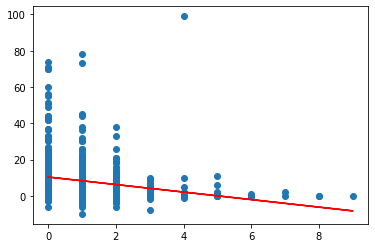

[10.337916789500484, 8.264809929822007, 6.191703070143532, 4.118596210465056, 2.04548935078658, -0.02761750889189507, -2.100724368570372, -4.173831228248849, -6.246938087927324, -8.3200449476058]


In [12]:
from sklearn.linear_model import LinearRegression
X = unique_plays.loc[:, 'closePlayers'].values.reshape(-1, 1)
Y = unique_plays.loc[:, 'kickReturnYardage'].values.reshape(-1, 1)
linear_regressor = LinearRegression() 
linear_regressor.fit(X, Y) 
Y_pred = linear_regressor.predict(X)

unique_plays['expectedReturn'] = Y_pred
unique_plays['returnOverExpected'] = unique_plays['kickReturnYardage']-unique_plays['expectedReturn']

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(sorted(unique_plays['expectedReturn'].unique(), reverse=True))

### 4.2 Querying By Team

We can now take the data for every unique punt return play and group by team to rank the performance of special teams units in 2018. 

We want to cover:
   * Punt Coverage - how well do teams get close to the opposing returner
   * Punt Return Coverage - how well do teams' opponents get close to the returner
   
For Punt Coverage:
 * Number of Punts
 * Average "Close" Players
 * Opponent Average Return Yardage
 * Opponent Average Return Yardage Over Expected
 * Percentage of Plays with 1+ "Close" Players
 * Percentage of Plays with Opposing Return Yardage of Less than 5

For Punt Return Coverage:
 * Number of Punt Returns
 * Opponent Average "Close" Players
 * Average Return Yardage
 * Average Return Yardage Over Expected
 * Percentage of Plays with 1+ Opposing "Close" Players
 * Percentage of Plays with Return Yardage of Less than 5

In [13]:
num_punt_coverages, avg_close_players, opp_avg_returns, num_punt_receives, opp_avg_close_players, avg_returns = [], [], [], [], [], []
avg_over_expected, opp_avg_over_expected  = [], []
at_least_one_close, opp_5_yards, opp_at_least_one_close, return_5_yards = [], [], [], []
for team in TEAMS:
    # Punt Coverages
    df = unique_plays[unique_plays['teamAbbr']==team]
    num_punt_coverages.append(len(df))
    avg_close_players.append(df['closePlayers'].mean())
    opp_avg_returns.append(df['kickReturnYardage'].mean())
    at_least_one_close.append(len(df[df['closePlayers']>=1])/len(df)*100)
    opp_5_yards.append(len(df[df['kickReturnYardage']<5])/len(df)*100)
    
    opp_avg_over_expected.append(df['returnOverExpected'].mean())
    
    # Punt Return Coverages
    df = unique_plays[unique_plays['returnTeam']==team]
    num_punt_receives.append(len(df))
    opp_avg_close_players.append(df['closePlayers'].mean())
    avg_returns.append(df['kickReturnYardage'].mean())
    opp_at_least_one_close.append(len(df[df['closePlayers']>=1])/len(df)*100)
    return_5_yards.append(len(df[df['kickReturnYardage']<5])/len(df)*100)
    
    avg_over_expected.append(df['returnOverExpected'].mean())

team_df = pd.DataFrame({'puntCoverages':num_punt_coverages, 'avgClosePlayers':avg_close_players, 'oppAvgReturns':opp_avg_returns, 'oppAvgOverExpected':opp_avg_over_expected, '%1+Close':at_least_one_close, 'opp%-5Return':opp_5_yards,
                        'puntReceives':num_punt_receives, 'oppAvgClosePlayers':opp_avg_close_players, 'avgReturns':avg_returns, 'avgOverExpected':avg_over_expected, 'opp%1+Close':opp_at_least_one_close, '%-5Return':return_5_yards})
team_df.index = TEAMS
team_df

,puntCoverages,avgClosePlayers,oppAvgReturns,oppAvgOverExpected,%1+Close,opp%-5Return,puntReceives,oppAvgClosePlayers,avgReturns,avgOverExpected,opp%1+Close,%-5Return
ARI,43,1.069767,9.558140,1.437965,60.465116,44.186047,36,0.833333,8.194444,-0.415883,55.555556,41.666667
ATL,27,1.518519,6.814815,-0.375051,70.370370,33.333333,19,0.526316,7.263158,-1.983650,31.578947,36.842105
BAL,31,0.516129,10.161290,0.893364,35.483871,25.806452,34,0.794118,11.352941,2.661315,44.117647,47.058824
BUF,34,0.911765,8.735294,0.287563,55.882353,50.000000,32,1.062500,6.281250,-1.853991,43.750000,46.875000
CAR,21,0.714286,8.476190,-0.380936,52.380952,33.333333,24,0.625000,6.875000,-2.167225,50.000000,50.000000
CHI,20,0.850000,7.500000,-1.075776,65.000000,30.000000,33,0.848485,12.424242,3.845325,57.575758,33.333333
CIN,29,0.793103,7.586207,-1.107522,65.517241,48.275862,22,0.954545,10.727273,2.368231,63.636364,31.818182
CLE,36,1.083333,10.750000,2.657949,63.888889,36.111111,32,1.156250,9.062500,1.121613,65.625000,34.375000
DAL,29,0.827586,9.034483,0.412241,62.068966,37.931034,20,0.950000,5.850000,-2.518465,60.000000,45.000000
DEN,32,1.281250,11.156250,3.474501,71.875000,46.875000,28,0.821429,4.392857,-4.242150,53.571429,60.714286


To identify the most relevant data points from above, we will use a heatmap to test correlations between 2 variables. What sticks out in particular is the correlation between the percentage of plays where there is 1+ "close" coverage players versus the % of plays where the opposing return yardage is 5 or less: there is a pearson correlation coefficient of .55 with a 0.001% chance that r = 0. 

(0.552871580185053, 0.0010322637846470243)


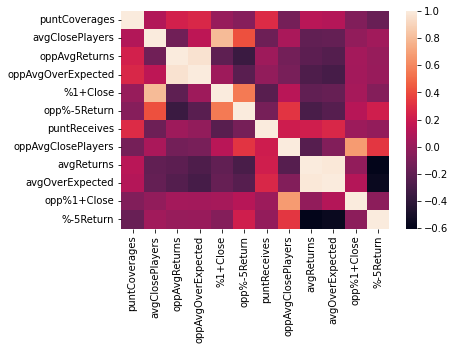

In [14]:
import seaborn as sns
corr_df = team_df.corr()
heatmap = sns.heatmap(corr_df)

print(stats.pearsonr(team_df['%1+Close'], team_df['opp%-5Return']))

### 4.3 Querying By Individual

For each individual coverage player with over 10 punt coverages, we find their average distance to the returner (at the moment the ball is caught) and percentage of plays where they were "close" to the returner.

We also find average return yardage they give up, although that cannot be entirely predicted by the performance of a single player.

In [15]:
def query_individual_data(min_plays = 10, gunner=None):
    if gunner == True:
        individual_df = punt_coverage_data[punt_coverage_data['gunner'] == 1]
    elif gunner == False:
        individual_df = punt_coverage_data[punt_coverage_data['gunner'] == 0]
    elif gunner == None:
        individual_df = punt_coverage_data
    total_plays = individual_df.groupby(['nflId']).size()
    total_plays = total_plays[total_plays >= min_plays]

    avg_distances = []
    names = []
    teams = []
    returns = []
    percent_close = []
    for i in total_plays.keys():
        df = punt_coverage_data[punt_coverage_data['nflId']==i]
        avg_distances.append(df['distanceToReturner'].mean())
        names.append(df.iloc[0]['displayName'])
        teams.append(df['teamAbbr'].unique()[0])
        returns.append(df['kickReturnYardage'].mean())
        
        close_df = df[df['distanceToReturner']<10]
        percent_close.append(len(close_df)/len(df))

    individual_df = pd.DataFrame({'totalPlays':total_plays, 'avgDistanceToReturner':avg_distances, 'Name':names, 
                                  'Team':teams, 'avgReturnYardage':returns, 'percentClose':percent_close})
    individual_df = individual_df.sort_values(by='avgReturnYardage')
    return individual_df

individual_df = query_individual_data()
individual_df = individual_df.sort_values(by='avgReturnYardage').head(10)
individual_df

,totalPlays,avgDistanceToReturner,Name,Team,avgReturnYardage,percentClose
nflId,,,,,,
38697.0,10,39.325691,George Iloka,MIN,2.666667,0.000000
46716.0,10,22.674867,Jordan Franks,CIN,3.600000,0.000000
46299.0,14,26.421432,Leon Jacobs,JAX,3.909091,0.071429
44974.0,13,24.973390,Anthony Walker,IND,4.181818,0.076923
46147.0,19,26.429077,Malik Jefferson,CIN,4.263158,0.052632
43719.0,10,33.620644,Josh Perkins,PHI,4.400000,0.000000
43645.0,33,30.249118,Jarrod Wilson,JAX,4.413793,0.060606
46700.0,21,16.927336,Tre Herndon,JAX,4.526316,0.238095
37230.0,10,27.051637,Niles Paul,JAX,4.666667,0.000000


<a id="Visualize"></a>
# 5. Visualize Data

Visualization templates from: https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e

### 5.1 Team Logos Setup

We will import the team logo images according to the nflfastR-Python guide above.

In [16]:
# Import Visualization Libraries
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# Create folder for logo images
logos_path = os.getcwd() + '/logos/'
if not os.path.exists(logos_path):
    os.makedirs(logos_path)

urls = pd.read_csv('https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv')

LOGO_PATHS = {}
for i in range(0,len(urls)):
    team = urls['team_code'].iloc[i]
    path = logos_path + team + '.png'
    urllib.request.urlretrieve(urls['url'].iloc[i], path)
    LOGO_PATHS[team] = path

### 5.2 Team Rankings: Punt Coverage

First we will graph teams based on the average number of players "close" to the punt returner on punt coverages

In other words, every time team X punts, about how many of their special teams players will be within 10 feet of the returner at the moment the returner catches the ball?

Based on the graph, we expect the Colts and Falcons in particular to have good punt coverage (thus having the least amount of avg. return yards) while the Ravens and Rams are expected to have poor punt coverage (the highest amount of avg. return yards). 

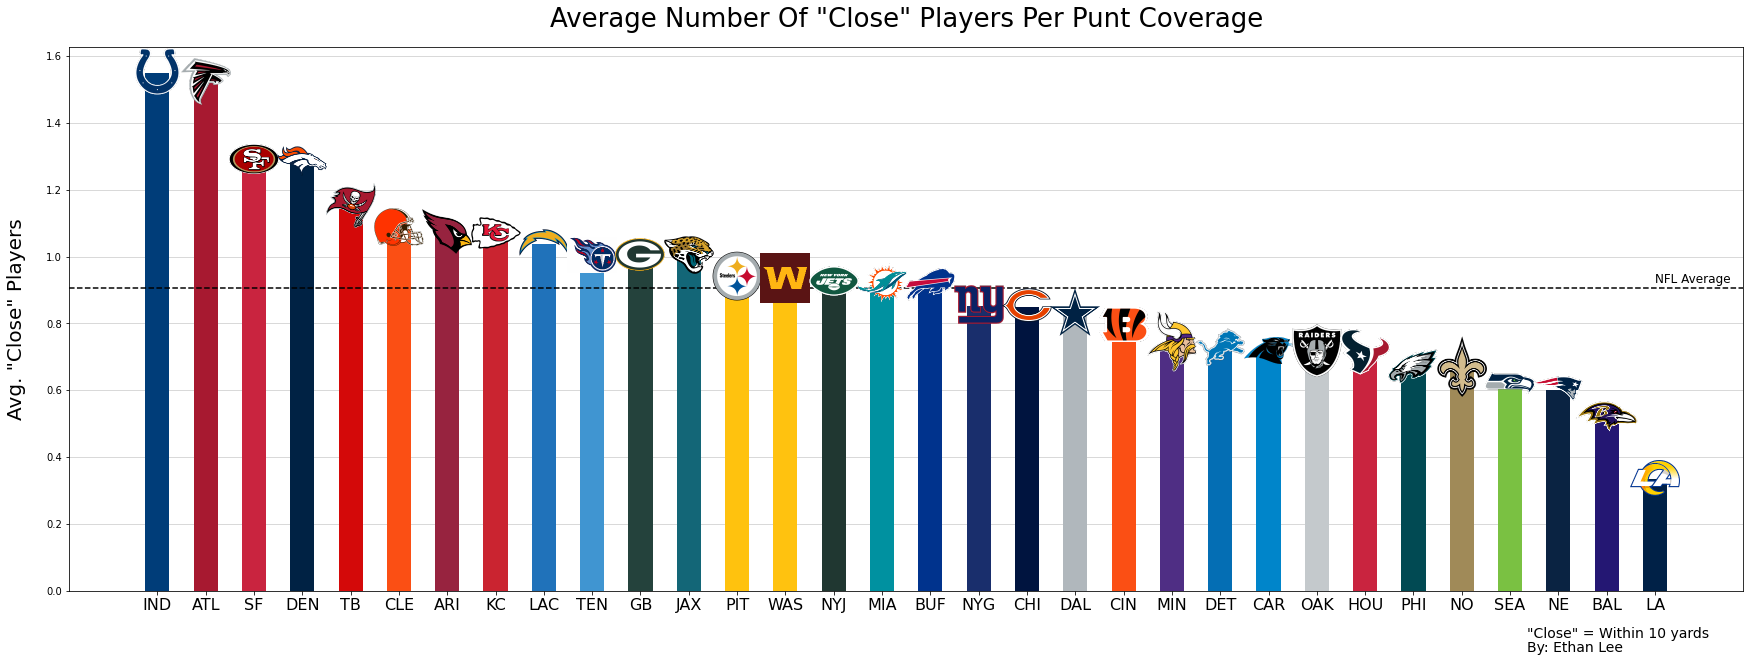

In [17]:
BASE_SIZE = 100
def getImage(path, basewidth=BASE_SIZE, zoom=0.5): 
    if 'BAL.png' in path:
        basewidth= int(basewidth*1.25)
    elif 'IND.png' in path:
        basewidth = int(basewidth*0.9)
    
    # Normalizing logo size
    img = Image.open(path)
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    img.save(path, bbox_inches='tight')
    
    # this lets you add images onto a chart
    return OffsetImage(plt.imread(path), zoom=zoom)

# Bar Graph Visualization
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','OAK':'#C4C9CC','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

CLOSE_FOOTNOTE = '"Close" = Within ' + str(CLOSE_THRESHOLD) + ' yards'

def teams_bar_graph(df, col, title, ycol, footnote='', ascending=False):
    df = df.sort_values(by=col, ascending=ascending)
    fig, ax = plt.subplots(figsize=(30,10))

    #Create league average line
    ax.axhline(y=df[col].mean(), linestyle='--', color='black')

    #Add team logos
    for x0, y0, path in zip(np.arange(0,32), df[col]+.005, [LOGO_PATHS[i] if i != 'OAK' else LOGO_PATHS['LV'] for i in df.index]):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
        ax.add_artist(ab)

    #Add bar chart, x axis is an array from 0-31 (length of 32, one per team)
    ax.bar(np.arange(0,32), df[col], color=[COLORS[i] for i in df.index], width=.5)

    #Add a grid across the y-axis
    ax.grid(zorder=0,alpha=.6,axis='y')
    ax.set_axisbelow(True)
    ax.set_xticks(np.arange(0,32))
    #Add team abbreviations as x tick labels
    ax.set_xticklabels(df.index,fontsize=16)

    ax.set_ylabel(ycol, fontsize=20, labelpad=20)
    ax.set_title(title, fontsize=26, pad=20)
    plt.figtext(.8, .06, footnote, fontsize=14)
    plt.figtext(.8, .04, 'By: Ethan Lee', fontsize=14)
    plt.text(31, df[col].mean()+.017, 'NFL Average', fontsize=12)
    
teams_bar_graph(team_df, 'avgClosePlayers', 'Average Number Of "Close" Players Per Punt Coverage', 'Avg. "Close" Players', CLOSE_FOOTNOTE)
# teams_bar_graph(team_df, 'oppAvgOverExpected', 'Average Opposing Punt Return Yardage Over Expected Per Punt Coverage', 'Yards')

In the below scatterplot, we see that while the Colts do have the lowest average punt return, teams like the Broncos and Browns do not have the predicted effect of lowering return yardage through a higher number of "close" players.

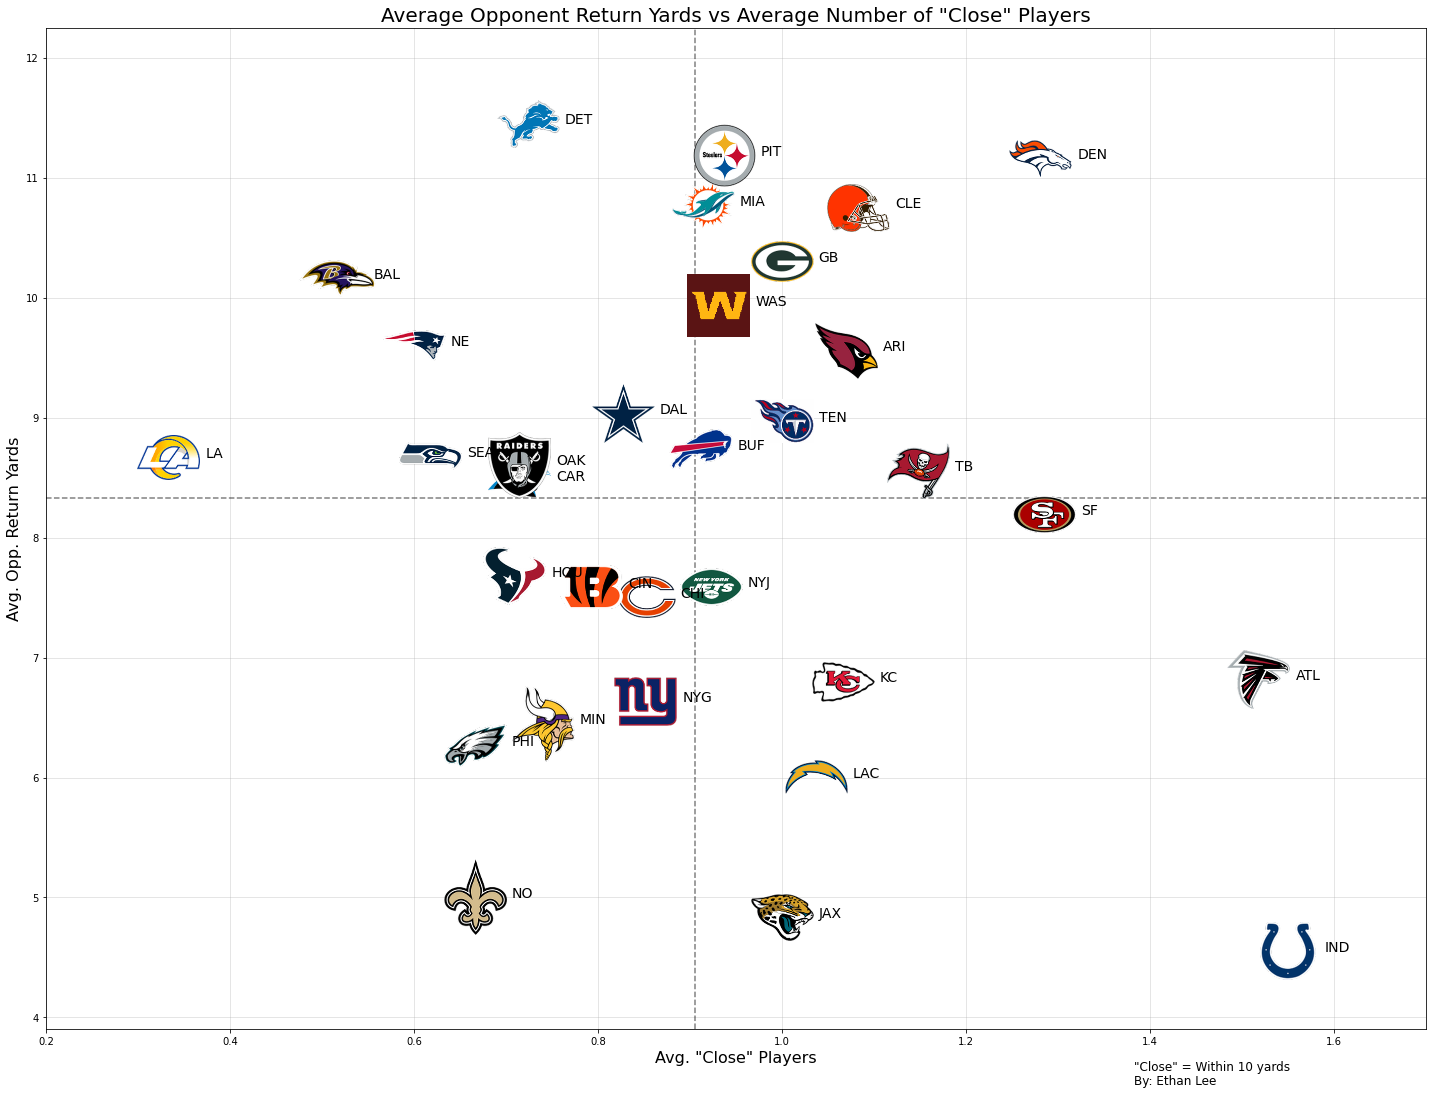

In [18]:
# Scatterplot Visualization
def teams_scatterplot(df, xcol, ycol, xlabel, ylabel, title, xlow=0, xhigh=30, ylow=0, yhigh=30, extra=0, footnote=''):
    # Adding logos to the chart
    fig, ax = plt.subplots(figsize=(20,15))
    for team, row in df.iterrows():
        x0 = row[xcol]
        y0 = row[ycol]

        if team == 'OAK':
            img = getImage(LOGO_PATHS['LV'], 125) 
        # TEN has a white background - can't seem to get rid of
        else:
            img = getImage(LOGO_PATHS[team], 125)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False, fontsize=4)
        ax.add_artist(ab)

    plt.xlim(xlow, xhigh)
    plt.ylim(ylow, yhigh)
    
    ax.axvline(x=df[xcol].mean(), linestyle='--', alpha=.5, color='black')
    ax.axhline(y=df[ycol].mean(), linestyle='--', alpha=.5, color='black')

    # Add a grid
    ax.grid(zorder=0,alpha=.4)
    ax.set_axisbelow(True)

    # Adding labels and text
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=20)
    plt.figtext(.79,-.008,'By: Ethan Lee',fontsize=12)
    plt.figtext(.79,.005, footnote, fontsize=12)
    
    # Label Logos
    for x0, y0, name in zip(df[xcol], df[ycol], df.index):
        plt.text(x=x0+extra , y = y0 , s=f"{name}" , fontdict=dict(fontsize=14), zorder=100)
        plt.tight_layout()

# Average Opponent Return Yards vs Average Number of Close Players
teams_scatterplot(team_df, 'avgClosePlayers', 'oppAvgReturns', 'Avg. "Close" Players', 'Avg. Opp. Return Yards', 
                 'Average Opponent Return Yards vs Average Number of "Close" Players', .2, 1.7, 3.9, 12.25, 0.04, footnote=CLOSE_FOOTNOTE)

#teams_scatterplot(team_df, 'avgClosePlayers', 'oppAvgOverExpected', 'Avg. "Close" Players', 'Avg. Opp. Return Yards', 
#                  'Average Opponent Return Yards Over Expected vs Average Number of Close Players', 0, 2, -4, 4)

Here we analyze the metrics with the highest correlations found in the heatmap earlier: 

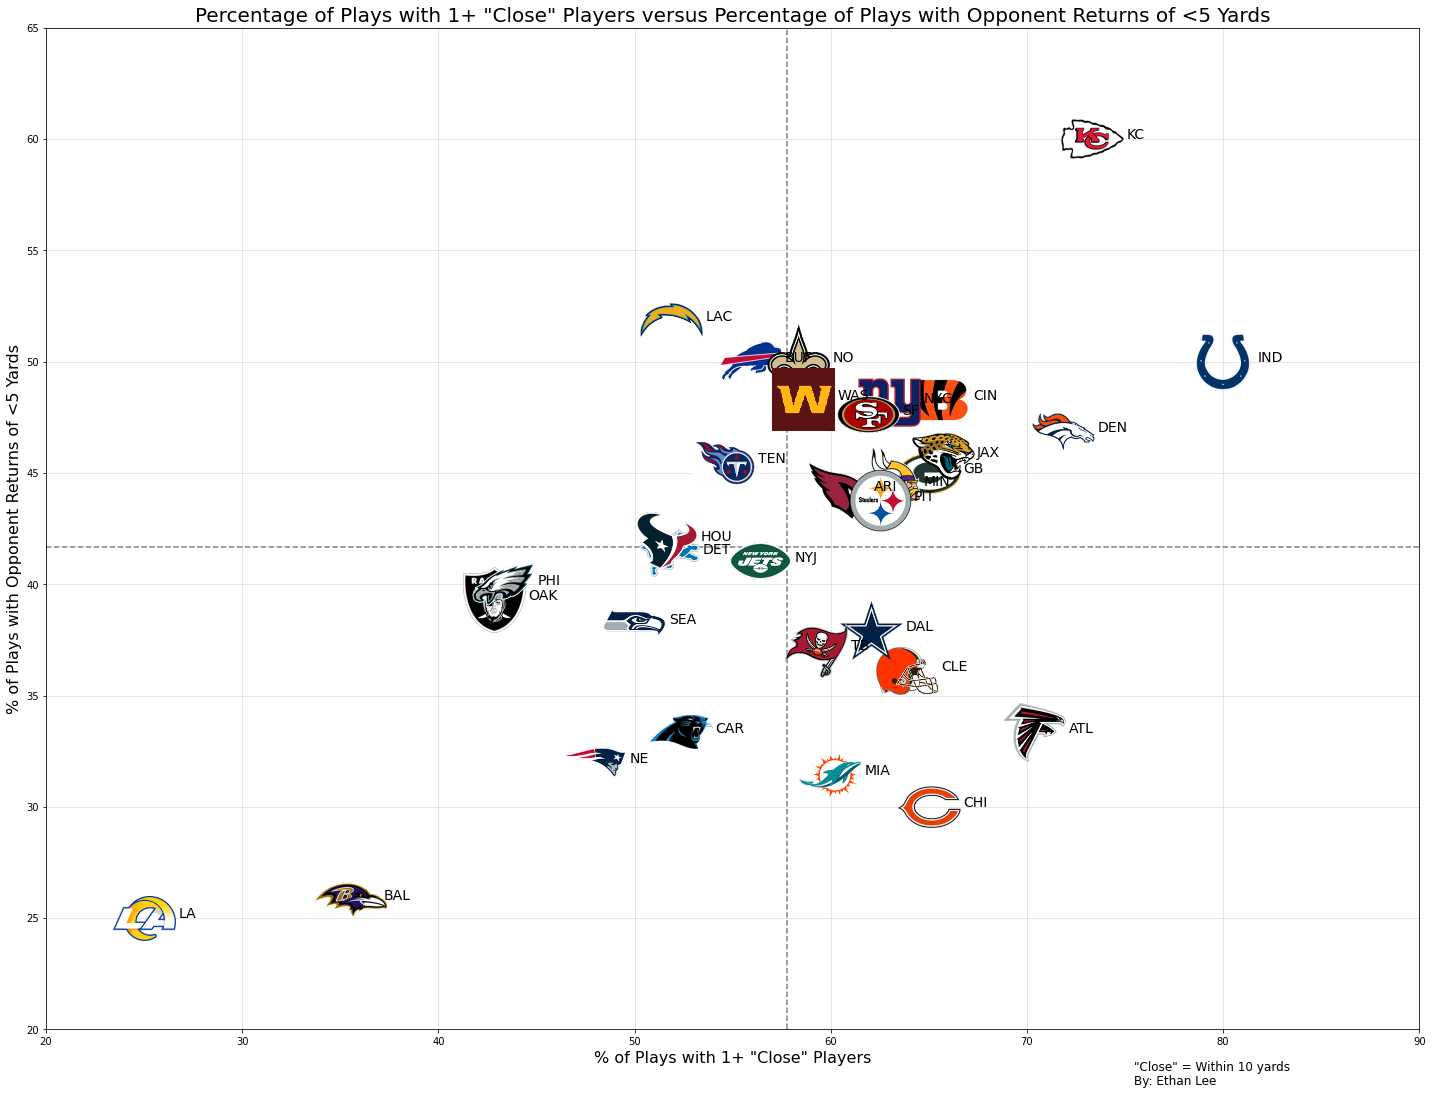

In [19]:
teams_scatterplot(team_df, '%1+Close', 'opp%-5Return', '% of Plays with 1+ "Close" Players', '% of Plays with Opponent Returns of <5 Yards', 
                  'Percentage of Plays with 1+ "Close" Players versus Percentage of Plays with Opponent Returns of <5 Yards' , 20, 90, 20, 65, 1.75, footnote=CLOSE_FOOTNOTE)

### 5.3 Team Rankings: Punt Return Coverage

The idea here is the same - as there are more "close" opponent players to the returner, there should be lower return yardage. Or, as there are less "close" opposing players to the returner, the returner will tend to gain more yardage. Based off of the graph, we expect the 49ers and Giants to have the highest opposing return yardage and the Panthers and Falcons to have the lowest opposing return yardage.

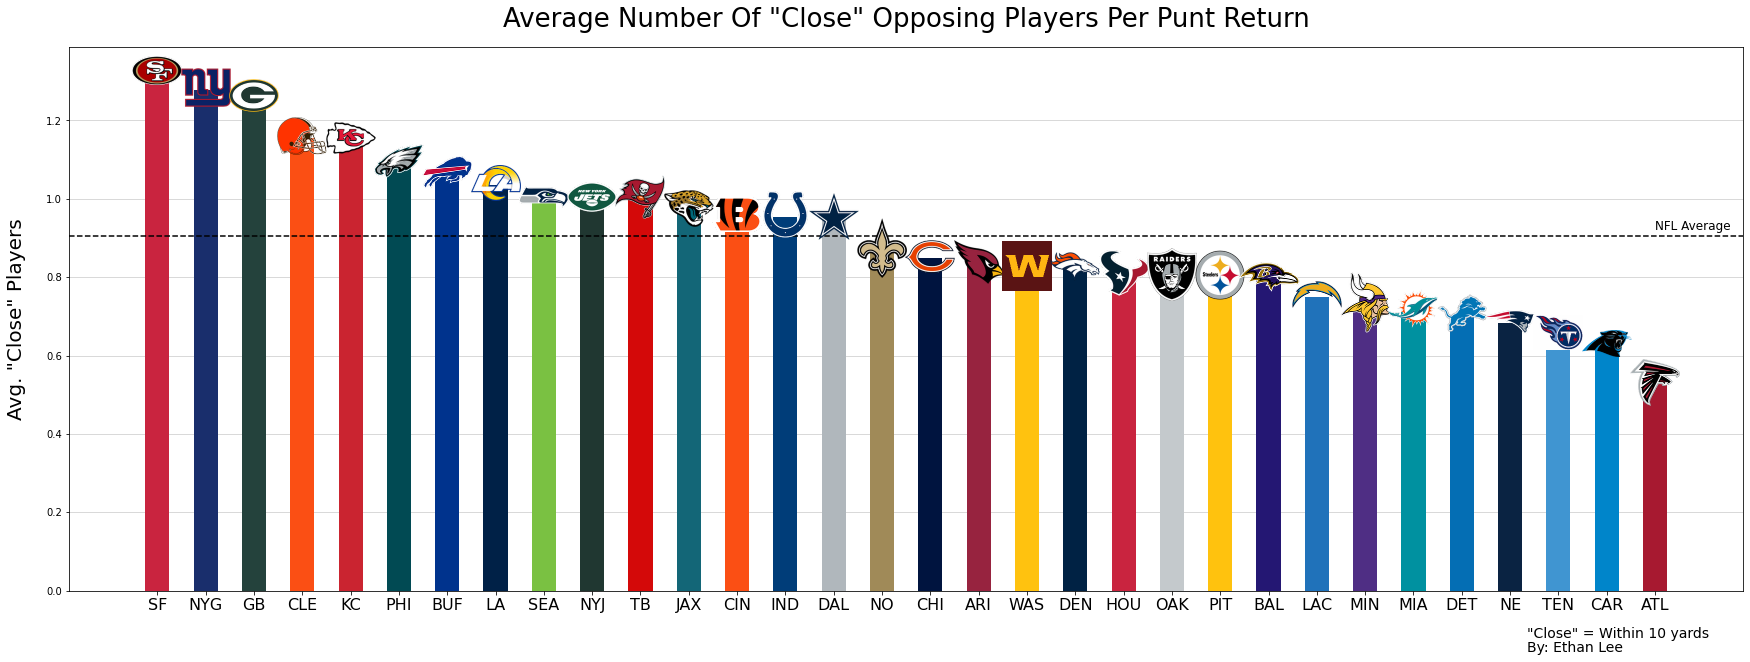

In [20]:
teams_bar_graph(team_df, 'oppAvgClosePlayers', 'Average Number Of "Close" Opposing Players Per Punt Return', 'Avg. "Close" Players', '"Close" = Within ' + str(CLOSE_THRESHOLD) + ' yards')

While the 49ers and Giants do have low average return yards, the Falcons and Panthers also have a below-average average return yards. There seems to be little correlation that the average return yards is affected by the average number of opposing "close" players.

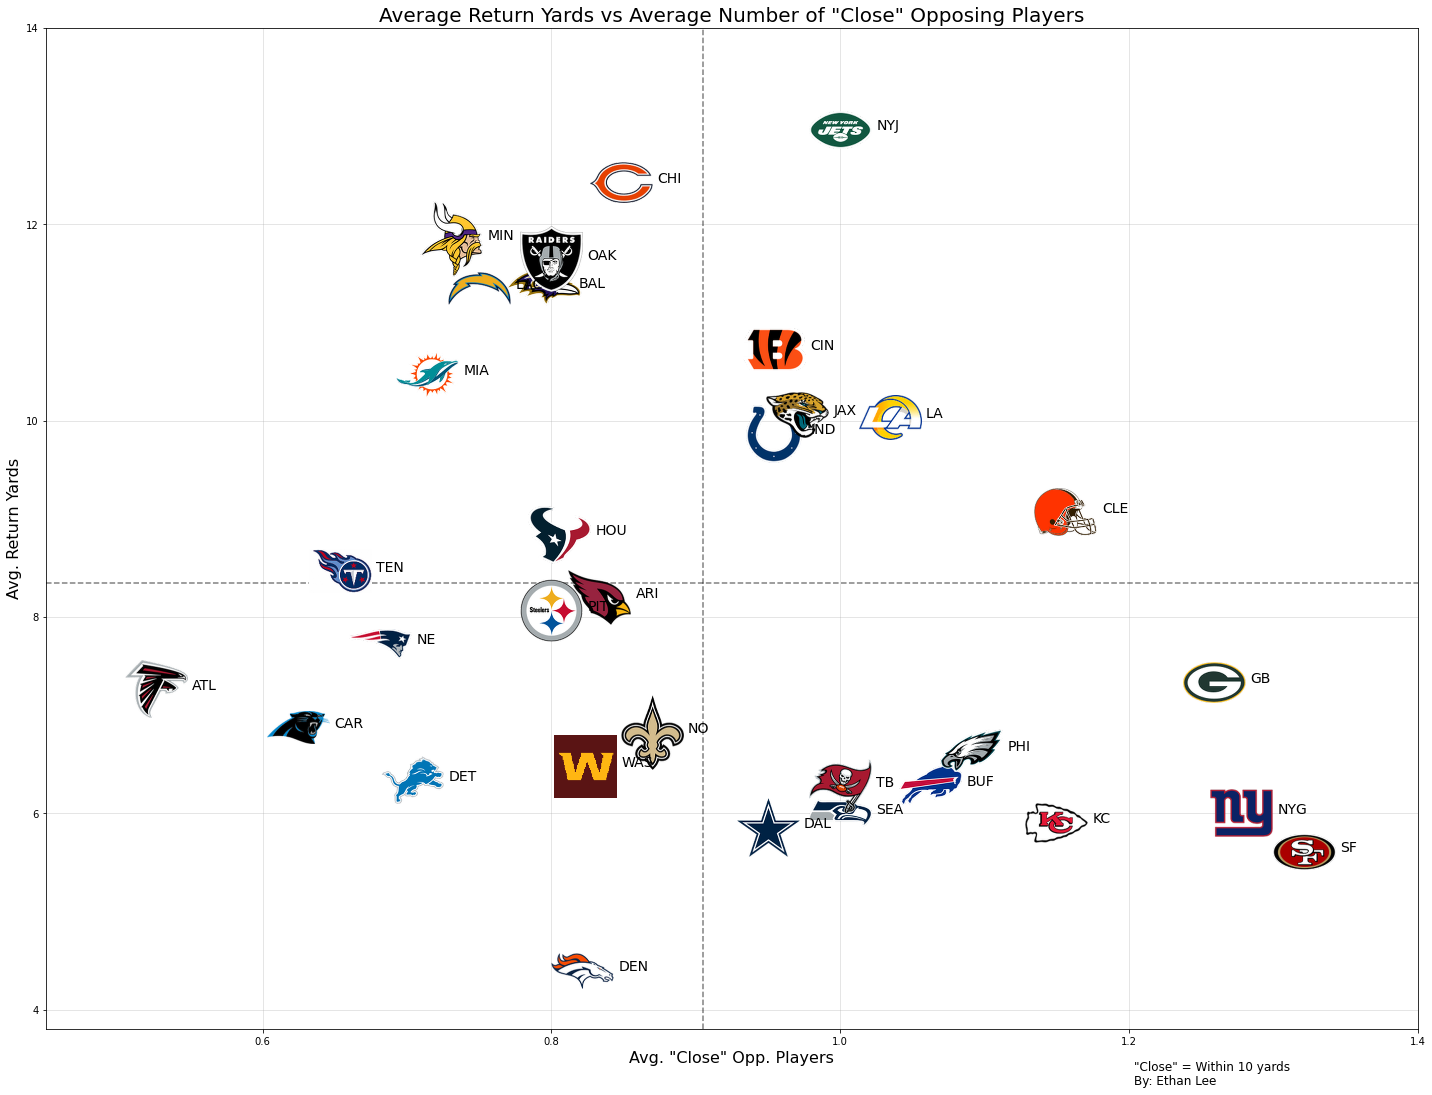

In [21]:
# Average Return Yards vs Average Number of "Close" Opposing Players
teams_scatterplot(team_df, 'oppAvgClosePlayers', 'avgReturns', 'Avg. "Close" Opp. Players', 'Avg. Return Yards', 
                  'Average Return Yards vs Average Number of "Close" Opposing Players', .45, 1.4, 3.8, 14, 0.025, footnote=CLOSE_FOOTNOTE)

### 5.4 Individual Gunner Rankings

Here we rank the top 20 gunners by the average distance from the returner (minimum 10 plays). 

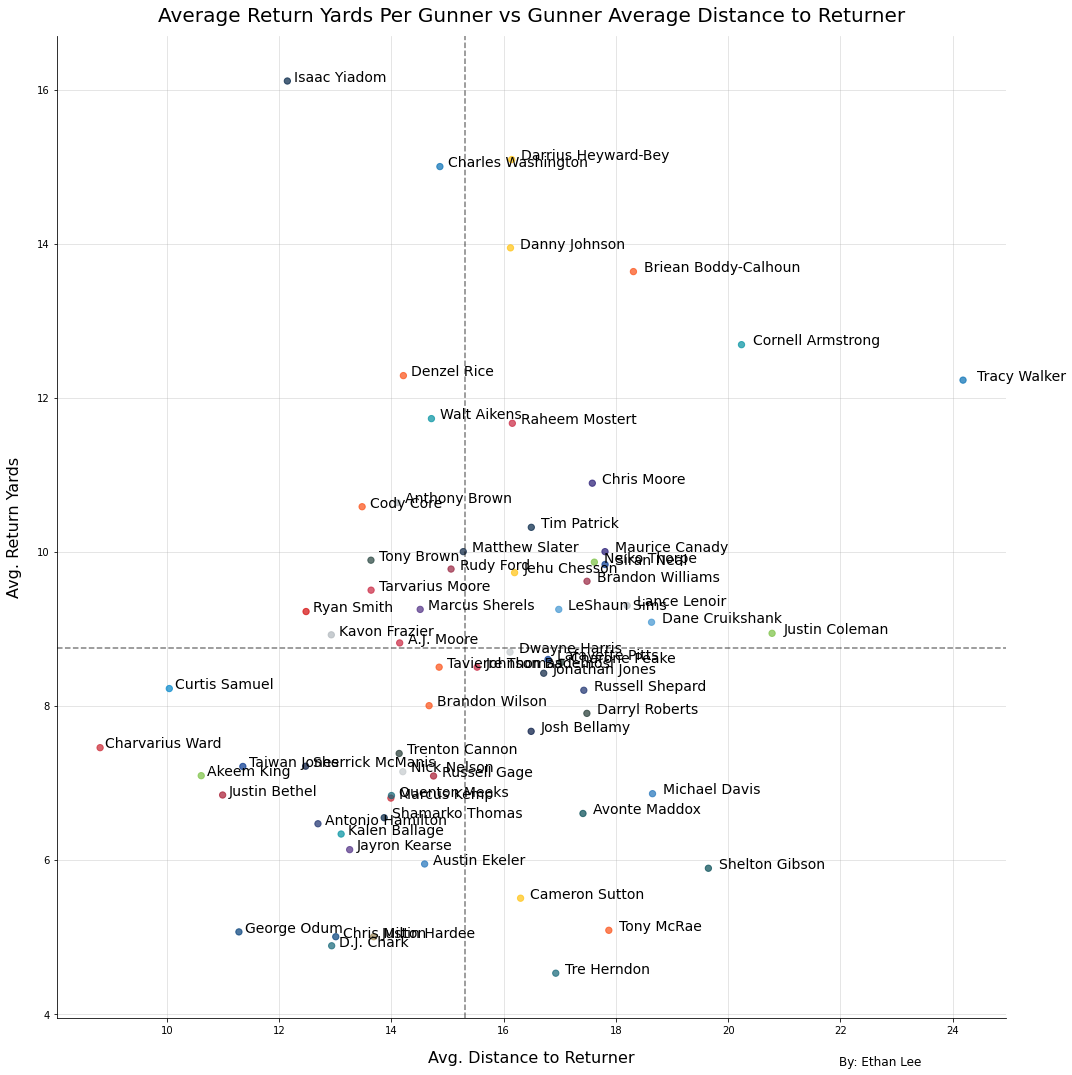

In [22]:
# Return Yardage vs Gunner Closing Distance

gunner_df = query_individual_data(min_plays=10, gunner=True)

def individual_scatterplot(df, xcol, ycol, title, xlab, ylab, close=False):
    fig, ax = plt.subplots(figsize=(15,15))

    #Create vertical and horizontal lines for averages of each metric
    x=df[xcol]
    y=df[ycol]
    ax.axvline(x=x.mean(), linestyle='--', alpha=.5, color='black')
    ax.axhline(y=y.mean(), linestyle='--', alpha=.5, color='black')

    #Create scatter plot
    #s stands for size, the dot size is proportional to the QBs number of plays
    ax.scatter(x, y, 
               s=40, 
               alpha=.7, 
               color=[COLORS[i] for i in df['Team']])

    #Add grid
    ax.grid(zorder=0,alpha=.4)
    ax.set_axisbelow(True)

    #Remove top and right boundary lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #Add title, labels, and source
    ax.set_title(title,fontsize=20,pad=15)
    ax.set_xlabel(xlab,fontsize=16,labelpad=15)
    ax.set_ylabel(ylab,fontsize=16,labelpad=15)
    plt.figtext(.78,.01,'By: Ethan Lee',fontsize=12)
    if close:
        plt.figtext(.78, .025, CLOSE_FOOTNOTE, fontsize=12)

    # Label Logos
    for x0, y0, name in zip(x, y, df['Name']):
        plt.text(x=1.01*x0 , y = y0 , s=f"{name}" , fontdict=dict(fontsize=14), zorder=100)
        plt.tight_layout()
        
individual_scatterplot(gunner_df, 'avgDistanceToReturner', 'avgReturnYardage',
                      'Average Return Yards Per Gunner vs Gunner Average Distance to Returner',
                      'Avg. Distance to Returner', 'Avg. Return Yards')

Here we rank the top 20 gunners by the percentage of plays where they were "close" to the returner on punt receive (minimum 10 plays).

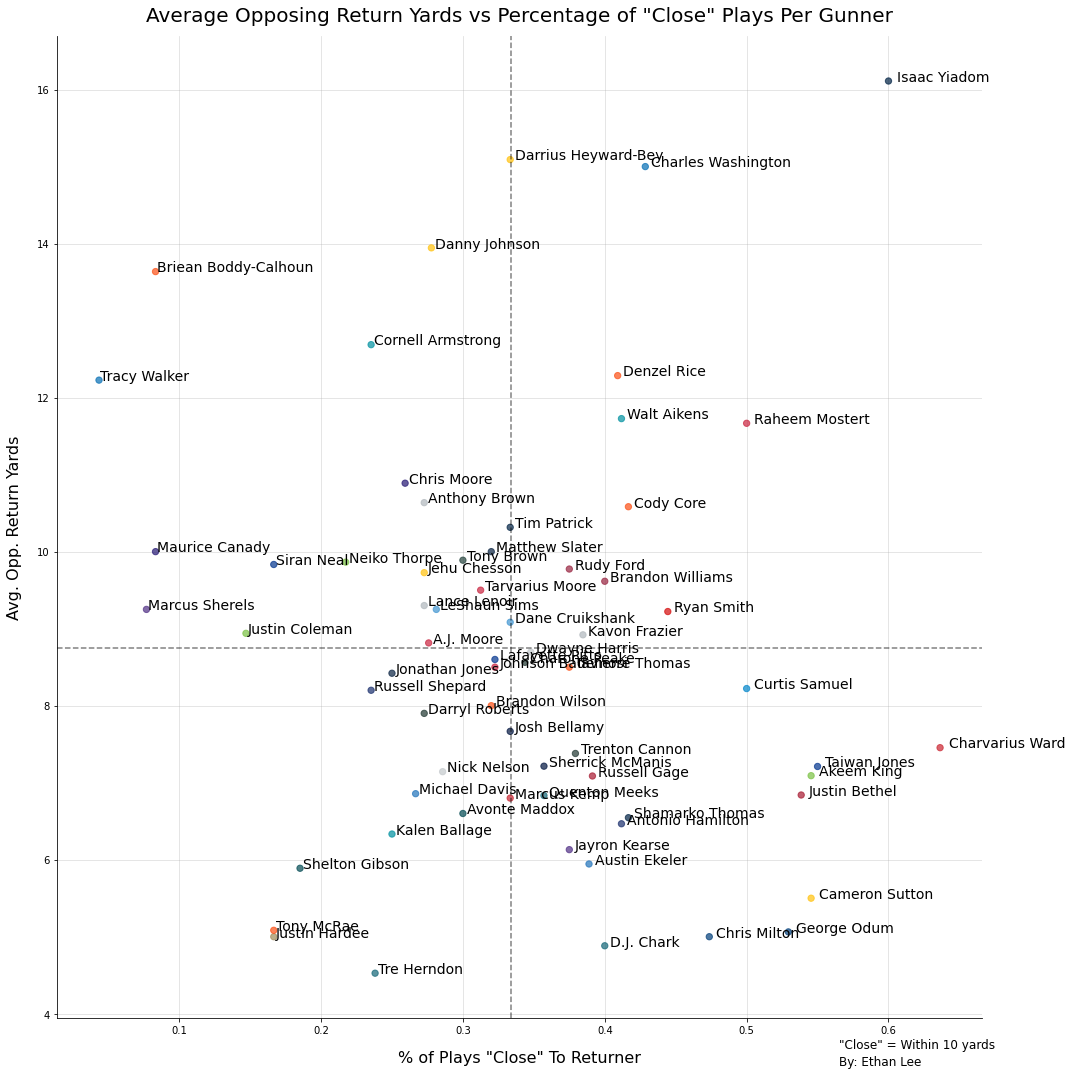

In [23]:
individual_scatterplot(gunner_df, 'percentClose', 'avgReturnYardage',
                      'Average Opposing Return Yards vs Percentage of "Close" Plays Per Gunner',
                      '% of Plays "Close" To Returner', 'Avg. Opp. Return Yards', True)

Here we identify the top 20 gunners based off of how often (or the % of plays, minimum 10) they were "close" to the returner at the moment the ball was received.

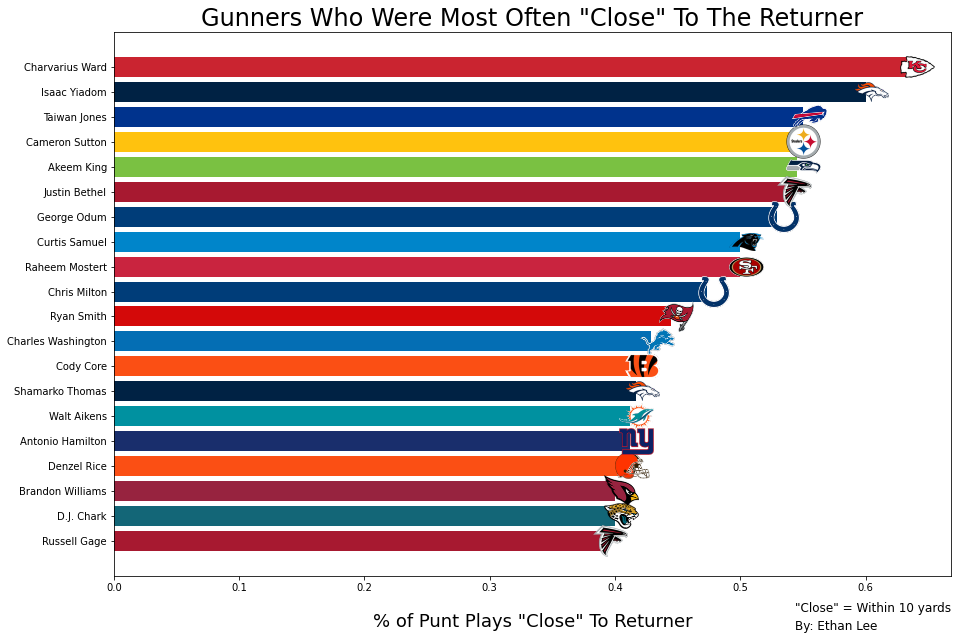

In [24]:
def individual_bar_graph(df, col, title, ycol, footnote='', ascending=True):
    df = df.sort_values(by=col, ascending=True)
    fig, ax = plt.subplots(figsize=(15,10))

    #Add team logos
    for y0, x0, path in zip(np.arange(0, len(df)), df[col]+.005, [LOGO_PATHS[i] if i != 'OAK' else LOGO_PATHS['LV'] for i in df['Team']]):
        ab = AnnotationBbox(getImage(path, 70), (x0, y0), frameon=False, fontsize=4)
        ax.add_artist(ab)

    #Add bar chart, x axis is an array from 0-31 (length of 32, one per team)
    ax.barh(df['Name'], df[col], color=[COLORS[i] for i in df['Team']])
    
    ax.set_title(title, fontsize=24)
    ax.set_xlabel(ycol, fontsize=18, labelpad=20)
                  
    plt.figtext(.756, .075, footnote, fontsize=12)
    plt.figtext(.756, .05, 'By: Ethan Lee', fontsize=12)
    
top_gunners = gunner_df.sort_values(by='percentClose', ascending=False).head(20)
individual_bar_graph(top_gunners, 'percentClose', 'Gunners Who Were Most Often "Close" To The Returner', '% of Punt Plays "Close" To Returner', CLOSE_FOOTNOTE)

Lastly, here is the ranking for the top 20 non-gunner coverage players, although their percentages are lower because it is harder for them to get "close" to the returner when they are first expected to block for the punter. 

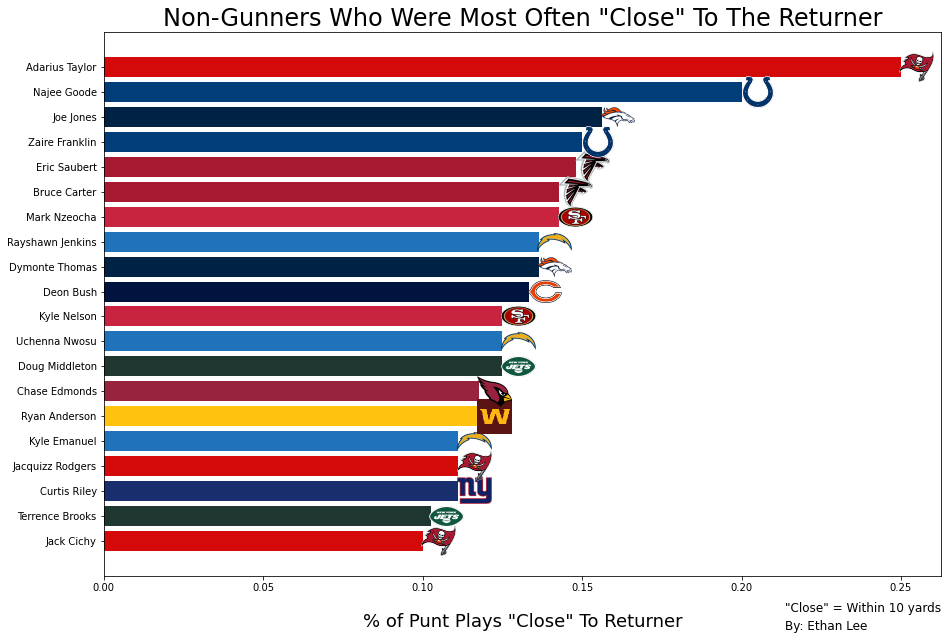

In [25]:
top_non_gunners = query_individual_data(gunner=False).sort_values(by='percentClose', ascending=False).head(20)
individual_bar_graph(top_non_gunners, 'percentClose', 'Non-Gunners Who Were Most Often "Close" To The Returner', '% of Punt Plays "Close" To Returner', CLOSE_FOOTNOTE)